# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [ ]:
import abc
import time
import typing

import tqdm
import torch
import numpy
import wandb
import random
import pandas
import sklearn.metrics
import sklearn.linear_model
import sklearn.preprocessing
import torch.utils.data as torchdata

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

RANDOM_STATE = 42
def set_random_seed(seed):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_random_seed(RANDOM_STATE)

In [ ]:
wandb.login(anonymous = "allow")

In [ ]:
! wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

In [ ]:
df = pandas.read_csv('data.txt.zip', header = None)
display(df)

Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [ ]:
class BaseModel(abc.ABC):
    def __init__(self):
        self.x_scaler = sklearn.preprocessing.StandardScaler()
        self.y_scaler = sklearn.preprocessing.StandardScaler()

    def preprocess(self, X: numpy.ndarray, y: typing.Optional[numpy.ndarray] = None):
        if (y is not None):
            # It is the train dataset
            y = y.reshape(-1, 1)
            X = self.x_scaler.fit_transform(X)
            y = self.y_scaler.fit_transform(y)
            return X, y.flatten()
        else:
            # It is the test dataset
            return self.x_scaler.transform(X)

    def postprocess(self, y_pred: numpy.ndarray) -> numpy.ndarray:
        y_pred = y_pred.reshape(-1, 1)
        return self.y_scaler.inverse_transform(y_pred).flatten()

    @abc.abstractmethod
    def fit(self, X: numpy.ndarray, y: numpy.ndarray):
        raise NotImplementedError

    @abc.abstractmethod
    def predict(self, X: numpy.ndarray) -> numpy.ndarray:
        raise NotImplementedError

In [ ]:
def RMSE(y_true: numpy.ndarray, y_pred: numpy.ndarray) -> float:
    assert y_true.shape == y_pred.shape
    return sklearn.metrics.mean_squared_error(y_true, y_pred, squared = False)

def calc_metrics(model: BaseModel) -> dict:
    return {
        'Train RMSE': RMSE(y_train, model.predict(X_train)),
        'Test RMSE': RMSE(y_test, model.predict(X_test)),
    }

In [ ]:
class RidgeRegresseion(BaseModel):
    def __init__(self, alpha = 1.0):
        super().__init__()
        self.model = sklearn.linear_model.Ridge(alpha)

    def fit(self, X: numpy.ndarray, y: numpy.ndarray):
        X, y = self.preprocess(X, y)
        self.model = self.model.fit(X, y)
        return self

    def predict(self, X: numpy.ndarray) -> numpy.ndarray:
      X = self.preprocess(X)
      y = self.model.predict(X)
      return self.postprocess(y)

set_random_seed(42)
calc_metrics(RidgeRegresseion().fit(X_train, y_train))

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [ ]:
class ConstantRegresseion(BaseModel):
    def fit(self, X: numpy.ndarray, y: numpy.ndarray):
        self.prediction = numpy.mean(y)
        return self

    def predict(self, X: numpy.ndarray) -> numpy.ndarray:
      return numpy.full(X.shape[0], self.prediction)

set_random_seed(42)
calc_metrics(ConstantRegresseion().fit(X_train, y_train))

## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [ ]:
class MyDataset(torchdata.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]

In [ ]:
class TorchBaseModel(BaseModel):
    def preprocess(self, X: numpy.ndarray, y: typing.Optional[numpy.ndarray] = None):
        if y is None:
            X = super().preprocess(X, y)
            return torch.tensor(X, dtype = torch.float32)
        else:
            X, y = super().preprocess(X, y)
            X = torch.tensor(X, dtype = torch.float32)
            y = torch.tensor(y, dtype = torch.float32)
            return X, y

    def postprocess(self, y_pred: torch.Tensor) -> numpy.ndarray:
        return super().postprocess(y_pred.cpu().detach().numpy())

In [ ]:
class TorchModel(TorchBaseModel):
    def __init__(
            self,
            name: str,
            batch_size: int,
            device: torch.device,
            model: torch.nn.Module,
            metrics: typing.Callable[[BaseModel], dict]
        ):
        super().__init__()
        self.name = name
        self.history = []
        self.device = device
        self.metrics = metrics
        self.batch_size = batch_size
        self.model = model.to(self.device)

    @abc.abstractmethod
    def train(self, dataset: MyDataset) -> float:
        raise NotImplementedError
        
    def fit(self, X: numpy.ndarray, y: numpy.ndarray, n_epochs: int = 1):
        X, y = self.preprocess(X, y)
        dataset = MyDataset(X.to(self.device), y.to(self.device))
        loader = torchdata.DataLoader(dataset, batch_size = self.batch_size, shuffle = True)
        
        wandb.init(project = "DL-HW-1", name = self.name, anonymous = "allow")
        wandb.watch(self.model, log = "all")

        for epoch in tqdm.trange(n_epochs):
            self.model.train()
            train_start = time.perf_counter()
            loss = self.train(loader)
            train_time = time.perf_counter() - train_start
            metrics = { 'Loss': loss, 'Train time': train_time }

            self.model.eval()
            val_start = time.perf_counter()
            with torch.no_grad():
                metrics.update(self.metrics(self))
            val_time = time.perf_counter() - val_start
            metrics['Validation time'] = val_time
            
            wandb.log(metrics)
            self.history.append(metrics)

        wandb.finish()
        return self
    
    def predict(self, X: numpy.ndarray) -> numpy.ndarray:
        self.model.eval()
        with torch.no_grad():
            X = self.preprocess(X)
            y = self.model(X.to(self.device))
            return self.postprocess(y)

In [ ]:
class MyTorchRegression(TorchModel):
    def __init__(self, learning_rate: float, **kwargs):
        super().__init__("MyTorchRegression", model = torch.nn.Linear(X.shape[1], 1), batch_size = 512, metrics = calc_metrics, **kwargs)
        self.learning_rate = learning_rate

    def train(self, loader: torchdata.DataLoader) -> float:
        for X, y in loader:
            y_pred = self.model(X).squeeze(1)
            loss = torch.mean(torch.square(y_pred - y))
            loss.backward()
            with torch.no_grad():
                self.model.weight -= self.learning_rate * self.model.weight.grad
                self.model.bias -= self.learning_rate * self.model.bias.grad
            self.model.weight.grad.zero_()
            self.model.bias.grad.zero_()
        return loss.item()
    
set_random_seed(42)
calc_metrics(MyTorchRegression(1e-3, device = device).fit(X_train, y_train, 10))

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [ ]:
class BestLinreg(TorchBaseModel):
    def preprocess(self, X: numpy.ndarray, y: typing.Optional[numpy.ndarray] = None):
        const_feature = torch.full((X.shape[0], 1), 1)
        if y is None:
            X = super().preprocess(X, y)
            return torch.cat([ X, const_feature ], dim = 1)
        else:
            X, y = super().preprocess(X, y)
            return torch.cat([ X, const_feature ], dim = 1), y
    
    def fit(self, X: numpy.ndarray, y: numpy.ndarray):
        X, y = self.preprocess(X, y)
        X_T = torch.transpose(X, 0, 1)
        self.weights = torch.inverse(X_T @ X) @ X_T @ y # Mathematically best weights
        return self
    
    def predict(self, X: numpy.ndarray) -> numpy.ndarray:
        X = self.preprocess(X)
        return self.postprocess(X @ self.weights)
    
set_random_seed(42)
calc_metrics(BestLinreg().fit(X_train, y_train))

Математически лучшая модель линейной регрессии показывает недостаточное качество. Следовательно, необходимо рассматривать сети, состоящие из нескольких полносвязных слоёв.

In [ ]:
class Model(TorchModel):
    def __init__(
            self,
            optimizer: torch.optim.Optimizer,
            scheduler: typing.Optional[torch.optim.lr_scheduler.LRScheduler] = None,
            **kwargs
        ):
        super().__init__(**kwargs)
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.loss = torch.nn.MSELoss()

    def train(self, loader: torchdata.DataLoader) -> float:
        for X, y in loader:
            self.optimizer.zero_grad()
            y_pred = self.model(X).squeeze(1)
            loss = self.loss(y_pred, y)
            loss.backward()
            self.optimizer.step()
        if self.scheduler is not None:
            self.scheduler.step()
        return loss.item()

In [ ]:
results = []
def try_model(**kwargs):
    if 'device' not in kwargs:
        kwargs['device'] = device

    if 'metrics' not in kwargs:
        kwargs['metrics'] = calc_metrics
    
    n_epochs = kwargs.get('n_epochs', 50)
    if 'n_epochs' in kwargs:
        del kwargs['n_epochs']
    
    model = Model(**kwargs)
    model.fit(X_train, y_train, n_epochs)
    final_metrics = calc_metrics(model)
    
    global last_tried_model
    last_tried_model = model

    results.append({
        '': '',
        'Name': kwargs['name'],
        'Best test RMSE': numpy.min([ metrics['Test RMSE'] for metrics in model.history ]),
        'Final test RMSE': final_metrics['Test RMSE'],
        'Best train RMSE': numpy.min([ metrics['Train RMSE'] for metrics in model.history ]),
        'Final train RMSE': final_metrics['Train RMSE'],
        "Average train time": numpy.mean([ metrics['Train time'] for metrics in model.history ]),
        "Average validation time": numpy.mean([ metrics['Validation time'] for metrics in model.history ])
    })
    return pandas.DataFrame(results)

### Выберем начальную модель
В качестве оптимизатора воспользуемся `AdamW`, так как этот алгоритм должен сам адаптировать скорость обучения под другие параметры. Таким образом, при экспериментах можно будет не задумываться над необходимостью корректировки большинства параметров: достаточно лишь минимально следить за изменениями метрик для предотварещния переобучения. \
В качестве начального размера пакета возьмём 256: это должно быть не очень мало, но и достаточно много, чтобы модель обучалась не очень долго

In [ ]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 45),
    torch.nn.ReLU(), torch.nn.Linear(45, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters())
try_model(name = "First model", model = model, optimizer = optimizer, batch_size = 256)

![Alternative Text][1697025643849]
Кажется, длина шага слишком большая. Графики RMSE как на тестовой, так и на тренировочной выборке выглядят не очень гладко, часто вырастают. Попробуем уменьшить длину шага.

[1697025643849]: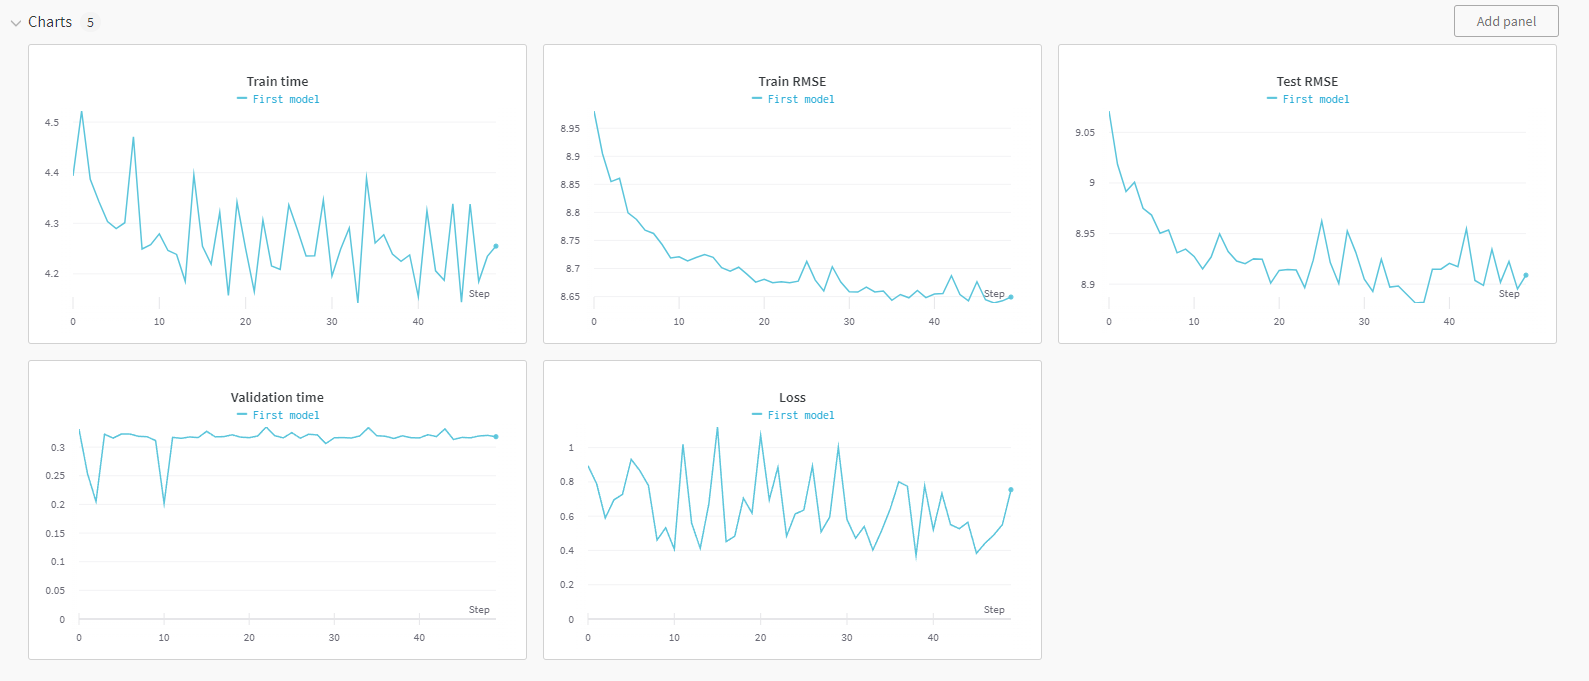

In [ ]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 45),
    torch.nn.ReLU(), torch.nn.Linear(45, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
try_model(name = "First model - 2", model = model, optimizer = optimizer, batch_size = 256)

![Alternative Text][1697025668549]
Однозначно стало лучше: модель обучается более плавно. Остановимся на этом.

[1697025668549]: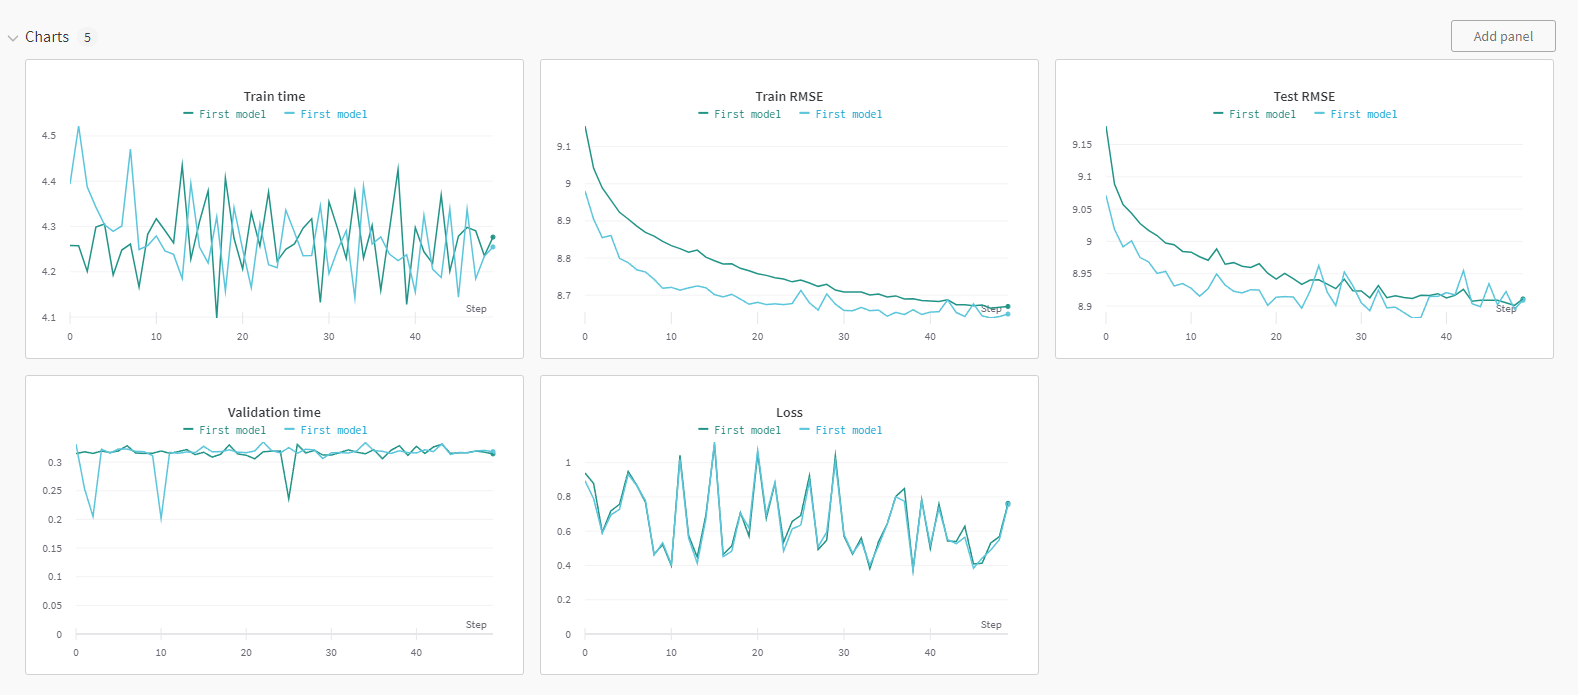

### Попробуем различное количество слоев
Будем распределять нейроны в скрытых слоях равномерно. Кажется, это должен быть оптимальный вариант.

In [ ]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 45),
    torch.nn.ReLU(), torch.nn.Linear(45, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
try_model(name = "45 neurons", model = model, optimizer = optimizer, batch_size = 256)

In [ ]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 60),
    torch.nn.ReLU(), torch.nn.Linear(60, 30),
    torch.nn.ReLU(), torch.nn.Linear(30, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
try_model(name = "60 + 30 neurons", model = model, optimizer = optimizer, batch_size = 256)

In [ ]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 65),
    torch.nn.ReLU(), torch.nn.Linear(65, 40),
    torch.nn.ReLU(), torch.nn.Linear(40, 20),
    torch.nn.ReLU(), torch.nn.Linear(20, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
try_model(name = "65 + 40 + 20 neurons", model = model, optimizer = optimizer, batch_size = 256)

In [ ]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 72),
    torch.nn.ReLU(), torch.nn.Linear(72, 54),
    torch.nn.ReLU(), torch.nn.Linear(54, 36),
    torch.nn.ReLU(), torch.nn.Linear(36, 18),
    torch.nn.ReLU(), torch.nn.Linear(18, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
try_model(name = "72 + 54 + 36 + 18 neurons", model = model, optimizer = optimizer, batch_size = 256)

![Alternative Text][1697025817572]
1 слоя явно мало, а 3 и 4 - много. Модель, имеющая один скрытый слой, явно недообучилась, а модели с 3 и 4 скрытыми слоями - переобучились: значение метрики на тестовой выборке убывало лишь на первых эпохах, после чего лишь возрастало - определение переобучения.

[1697025817572]: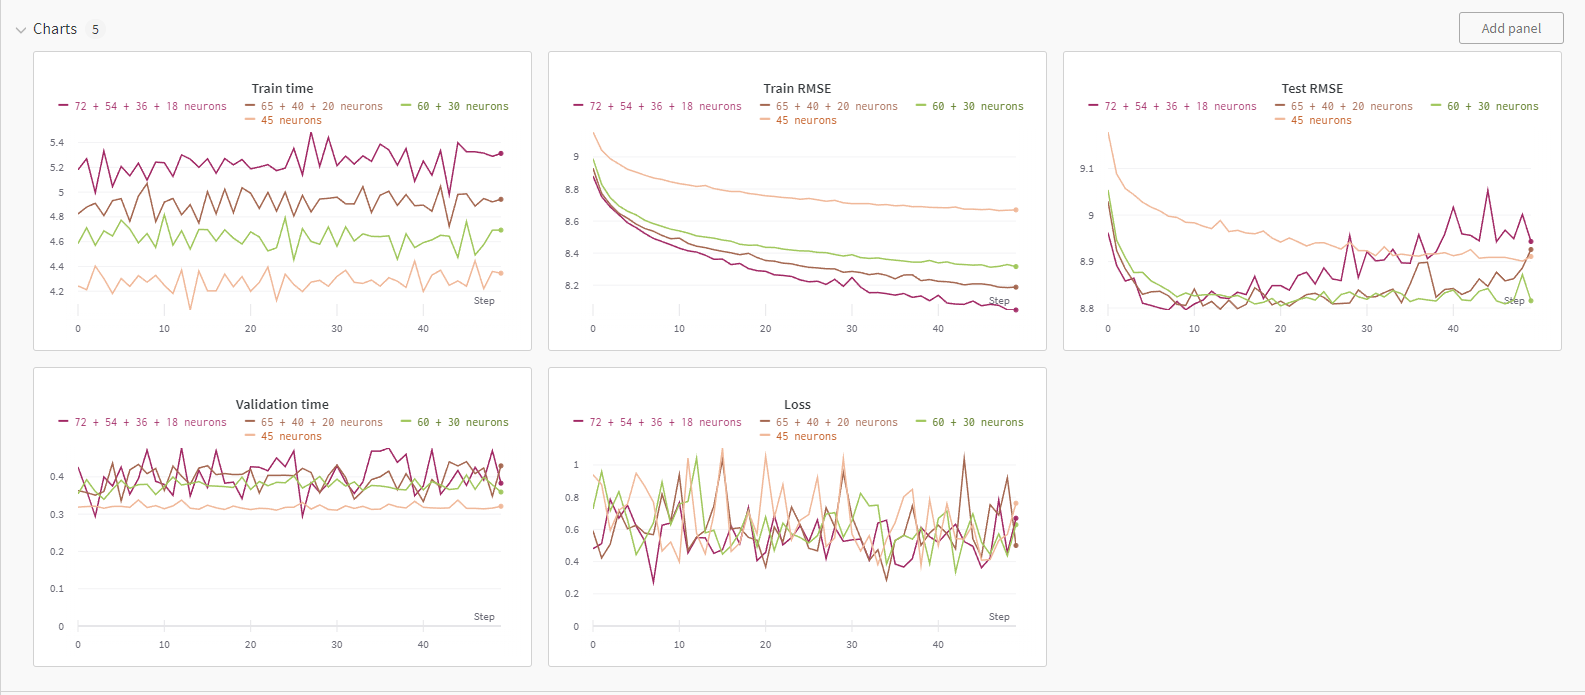

### Попробуем различный размер батча

In [ ]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 60),
    torch.nn.ReLU(), torch.nn.Linear(60, 30),
    torch.nn.ReLU(), torch.nn.Linear(30, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
try_model(name = "32 Batch", model = model, optimizer = optimizer, batch_size = 32)

![Alternative Text][1697025940054]
Размер шага явно слишком большой. Получается, при уменьшении размера пакета, длину шага также нужно уменьшать.

[1697025940054]: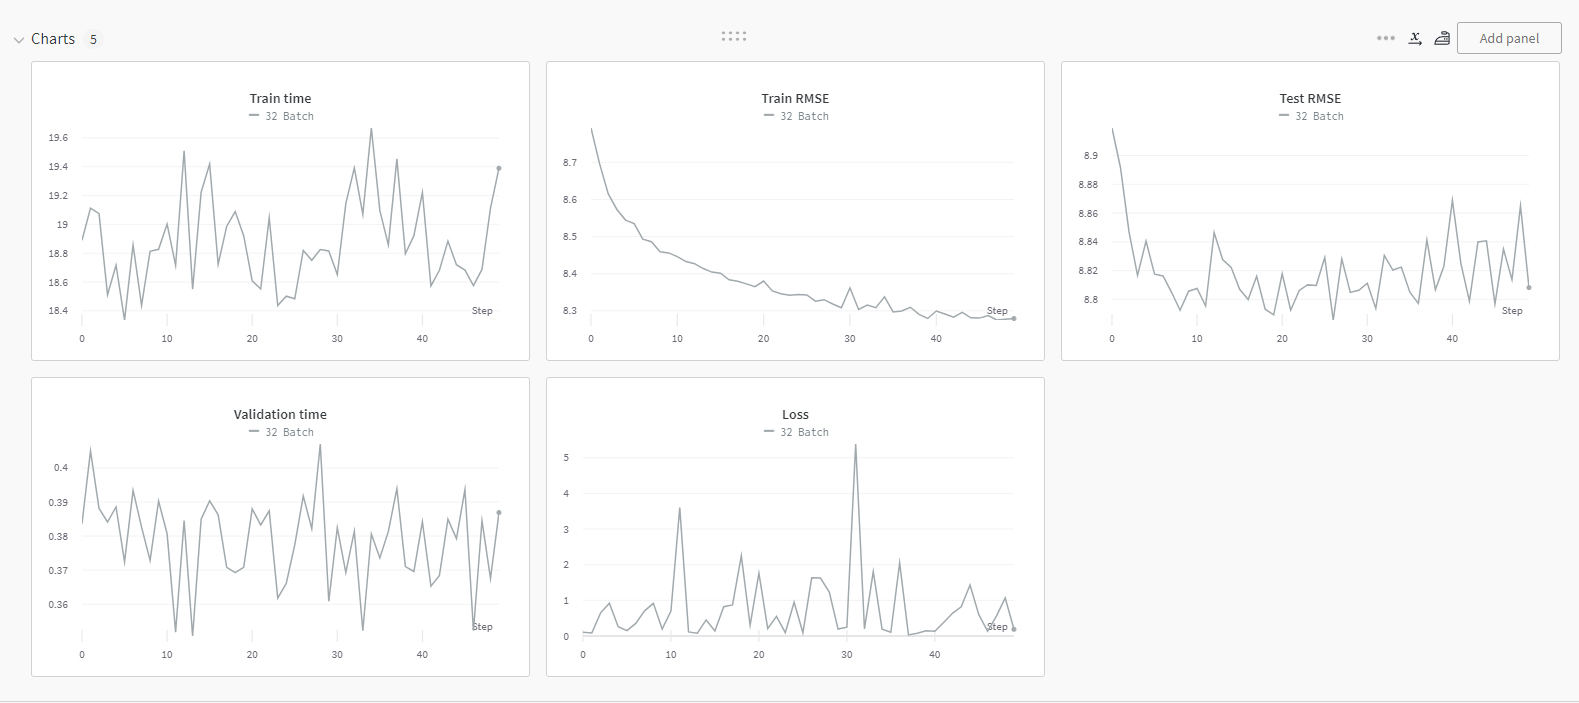

In [ ]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 60),
    torch.nn.ReLU(), torch.nn.Linear(60, 30),
    torch.nn.ReLU(), torch.nn.Linear(30, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5)
try_model(name = "32 Batch - smaller lr", model = model, optimizer = optimizer, batch_size = 32)

In [ ]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 60),
    torch.nn.ReLU(), torch.nn.Linear(60, 30),
    torch.nn.ReLU(), torch.nn.Linear(30, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 4e-5)
try_model(name = "64 Batch", model = model, optimizer = optimizer, batch_size = 64)

In [ ]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 60),
    torch.nn.ReLU(), torch.nn.Linear(60, 30),
    torch.nn.ReLU(), torch.nn.Linear(30, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-5)
try_model(name = "128 Batch", model = model, optimizer = optimizer, batch_size = 128)

In [ ]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 60),
    torch.nn.ReLU(), torch.nn.Linear(60, 30),
    torch.nn.ReLU(), torch.nn.Linear(30, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
try_model(name = "256 Batch", model = model, optimizer = optimizer, batch_size = 256)

In [ ]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 60),
    torch.nn.ReLU(), torch.nn.Linear(60, 30),
    torch.nn.ReLU(), torch.nn.Linear(30, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 4e-4)
try_model(name = "512 Batch", model = model, optimizer = optimizer, batch_size = 512)

In [ ]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 60),
    torch.nn.ReLU(), torch.nn.Linear(60, 30),
    torch.nn.ReLU(), torch.nn.Linear(30, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 8e-4)
try_model(name = "1024 Batch", model = model, optimizer = optimizer, batch_size = 1024)

![Alternative Text][1697038110085]
Можно заметить, что большой размер пакета (512, 1024) приводит к переобучению, но в остальном размер пакета не оказывает значительного влияния на качество модели при соответствующей корректировке размера шага. Тем не менее обучение на пакетах маленького размера происходит заметно дольше, поэтому для дальнейших экспериментов продолжим использовать размер пакета 256.

[1697038110085]: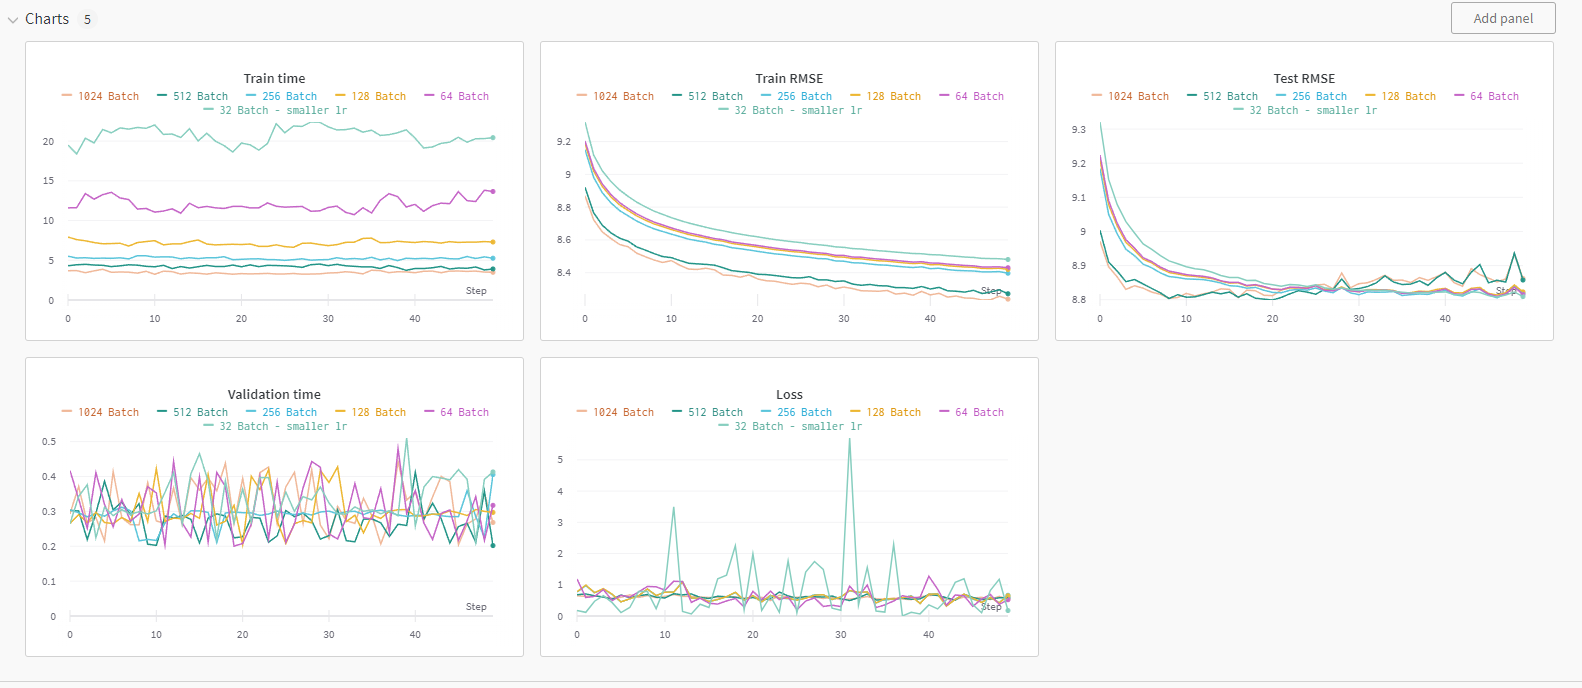

### Попробуем различные оптимизаторы

In [ ]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 60),
    torch.nn.ReLU(), torch.nn.Linear(60, 30),
    torch.nn.ReLU(), torch.nn.Linear(30, 1)
).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)
try_model(name = "SGD", model = model, optimizer = optimizer, batch_size = 256)

In [ ]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 60),
    torch.nn.ReLU(), torch.nn.Linear(60, 30),
    torch.nn.ReLU(), torch.nn.Linear(30, 1)
).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-4, momentum = 0.9)
try_model(name = "SGD with momentum", model = model, optimizer = optimizer, batch_size = 256)

In [ ]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 60),
    torch.nn.ReLU(), torch.nn.Linear(60, 30),
    torch.nn.ReLU(), torch.nn.Linear(30, 1)
).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3, weight_decay = 0.01)
try_model(name = "SGD with weight decay", model = model, optimizer = optimizer, batch_size = 256)

In [ ]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 60),
    torch.nn.ReLU(), torch.nn.Linear(60, 30),
    torch.nn.ReLU(), torch.nn.Linear(30, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
try_model(name = "SGD with momentum", model = model, optimizer = optimizer, batch_size = 256)

Таким образом, добавление момента и регуляризации в алгоритм не оказывает значительного влияния на качество: сильного переобучения модели не наблюдается. Тем не менее `AdamW` всё равно оказывается значительно лучше. Дальше будем использовать его.

### Попробуем различные нелинейности
Для ускорения обучения моделей будем обучать всего 10 эпох. Этого должно быть достаточно для выявления общих закономерностей.

In [ ]:
def test_activation(name: str, activation_module: torch.nn.Module):
    set_random_seed(42)
    model = torch.nn.Sequential(
        torch.nn.Linear(90, 60),
        activation_module, torch.nn.Linear(60, 30),
        activation_module, torch.nn.Linear(30, 1)
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
    return try_model(name = name, model = model, optimizer = optimizer, batch_size = 256, n_epochs = 10)

In [ ]:
test_activation("ELU", torch.nn.ELU())

In [ ]:
test_activation("LeakyReLU", torch.nn.LeakyReLU())

In [ ]:
test_activation("PReLU", torch.nn.PReLU())

In [ ]:
test_activation("RReLU", torch.nn.RReLU())

In [ ]:
test_activation("ReLU", torch.nn.ReLU())

In [ ]:
test_activation("SELU", torch.nn.SELU())

In [ ]:
test_activation("CELU", torch.nn.CELU())

In [ ]:
test_activation("GELU", torch.nn.GELU())

In [ ]:
test_activation("Sigmoid", torch.nn.Sigmoid())

In [ ]:
test_activation("SiLU", torch.nn.SiLU())

In [ ]:
test_activation("Mish", torch.nn.Mish())

In [ ]:
test_activation("Softplus", torch.nn.Softplus())

In [ ]:
test_activation("Softshrink", torch.nn.Softshrink())

In [ ]:
test_activation("Softsign", torch.nn.Softsign())

In [ ]:
test_activation("Tanh", torch.nn.Tanh())

Таким образом, от выбора функции активации качество модели зависит не сильно. Можно лишь выделить, что Sigmoid показывает себя однозначно хуже остальных, Softplus и Softshrink - немного хуже. Остальные функции активации позволяют достичь примерно одинакового качества, но ReLU и GELU - немного лучше. Далее будем использовать GELU.

### Другие эксперименты

Говорят, добавление нормализации между слоями должно повышать качество

In [ ]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 60), torch.nn.BatchNorm1d(60),
    torch.nn.GELU(), torch.nn.Linear(60, 30), torch.nn.BatchNorm1d(30),
    torch.nn.GELU(), torch.nn.Linear(30, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
try_model(name = "BatchNorm", model = model, optimizer = optimizer, batch_size = 256)

Достаточное качество не было достигнуто. Попробуем поменять количество нейронов в скрытых слоях - это единственное, что мы еще не делали.

In [ ]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 90), torch.nn.BatchNorm1d(90),
    torch.nn.GELU(), torch.nn.Linear(90, 60), torch.nn.BatchNorm1d(60),
    torch.nn.GELU(), torch.nn.Linear(60, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
try_model(name = "Final attempt 1", model = model, optimizer = optimizer, batch_size = 256)

Качество немного увеличилось, но теперь явно наблюдается переобучение. Попробуем воспользоваться методом борьбы с переобучением - Dropout

In [ ]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 90), torch.nn.BatchNorm1d(90),
    torch.nn.GELU(), torch.nn.Dropout(0.2), torch.nn.Linear(90, 60), torch.nn.BatchNorm1d(60),
    torch.nn.GELU(), torch.nn.Dropout(0.2), torch.nn.Linear(60, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
try_model(name = "Dropout", model = model, optimizer = optimizer, batch_size = 256)

Качество заметно увеличилось и переобучение больше не наблюдается. Тем не менее необходимого качества модель не достигла. Попробуем добавить ещё один слой: как было получено ранее, это повышает качество, но ведёт к переобучению.

In [ ]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 90), torch.nn.BatchNorm1d(90),
    torch.nn.GELU(), torch.nn.Dropout(0.2), torch.nn.Linear(90, 60), torch.nn.BatchNorm1d(60),
    torch.nn.GELU(), torch.nn.Dropout(0.2), torch.nn.Linear(60, 30), torch.nn.BatchNorm1d(30),
    torch.nn.GELU(), torch.nn.Dropout(0.2), torch.nn.Linear(30, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
try_model(name = "90 + 60 + 30 neurons", model = model, optimizer = optimizer, batch_size = 256)

### Результат
Наилучшее качество было достигнуто на 41 эпохе. Воспользуемся этим значением.

In [ ]:
set_random_seed(42)

model = torch.nn.Sequential(
    torch.nn.Linear(90, 90), torch.nn.BatchNorm1d(90),
    torch.nn.GELU(), torch.nn.Dropout(0.2), torch.nn.Linear(90, 60), torch.nn.BatchNorm1d(60),
    torch.nn.GELU(), torch.nn.Dropout(0.2), torch.nn.Linear(60, 30), torch.nn.BatchNorm1d(30),
    torch.nn.GELU(), torch.nn.Dropout(0.2), torch.nn.Linear(30, 1)
).to(device)

model = Model(
    name = "Final model",
    model = model,
    optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4),
    batch_size = 256,
    device = device,
    metrics = calc_metrics
)
model.fit(X_train, y_train, 41)
calc_metrics(model)

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.